In [ ]:
import os, time
import numpy as np
import random
random.seed(42)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

import torch
torch.manual_seed(42)
from torch import nn
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.data.dataset import Dataset
from torchvision.models import resnet
from torchvision import transforms, datasets, models
from torch.optim.lr_scheduler import ReduceLROnPlateau

print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.5.1 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [ ]:
def load_transform_images(images_path, presplit, train_split, test_split, val_split, batch_size, threads, mean, std):
    train_transform = transforms.Compose([
                                         #transforms.RandomRotation(degrees=15),
                                         #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                                         #transforms.RandomResizedCrop((224,224)),
                                         transforms.Resize((224,224)),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize(torch.Tensor(mean),
                                                              torch.Tensor(std))])

    test_transform = transforms.Compose([
                                        transforms.Resize((224,224)),
                                        #transforms.CenterCrop((224,224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(torch.Tensor(mean),
                                                             torch.Tensor(std))])

    val_transform = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       #transforms.CenterCrop((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(torch.Tensor(mean),
                                                            torch.Tensor(std))])

    if presplit:
        try:
            training_set = datasets.ImageFolder(root=images_path+'/Training', transform=train_transform)
            validation_set = datasets.ImageFolder(root=images_path+'/Test', transform=val_transform)
        except FileNotFoundError:
            raise Exception('Not presplit into Training and Validation sets')
        try:
            testing_set = datasets.ImageFolder(root=images_path+'/val', transform=test_transform)
        except:
            testing_set = validation_set
        dataset = training_set
    else:
        dataset = datasets.ImageFolder(root=images_path, transform=train_transform)
        train_size = int(train_split * len(dataset))
        test_size = int(test_split * len(dataset))
        val_size = len(dataset) - train_size - test_size
        training_set, testing_set, validation_set = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])
    
    training_set_loader = DataLoader(training_set, batch_size=batch_size, num_workers=threads, shuffle=True)
    validation_set_loader = DataLoader(validation_set, batch_size=batch_size, num_workers=threads, shuffle=True)
    testing_set_loader = DataLoader(testing_set, batch_size=batch_size, num_workers=threads, shuffle=False)

    return training_set_loader, testing_set_loader, validation_set_loader, dataset, training_set, testing_set, validation_set

def load_network(net_model, net_name, dropout_ratio, class_names):
    for name, param in net_model.named_parameters():
        param.requires_grad = False

    if net_name.startswith('resnet'):
        num_ftrs = net_model.fc.in_features
        net_model.fc = nn.Sequential(nn.Linear(num_ftrs, 256),
                                     nn.ReLU(),
                                     nn.Dropout(p=dropout_ratio),
                                     nn.Linear(256, len(class_names)))
        display(net_model)

    elif net_name.startswith('vgg'):
        num_ftrs = net_model.classifier[6].in_features
        net_model.classifier[6] = nn.Sequential(nn.Linear(num_ftrs, 256),
                                                nn.ReLU(),
                                                nn.Dropout(p=dropout_ratio),
                                                nn.Linear(256, len(class_names)))
        display(net_model.classifier)
    
    total_params = sum(param.numel() for param in net_model.parameters())
    print(f'{total_params:,} total parameters')

    total_trainable_params = sum(param.numel() for param in net_model.parameters() if param.requires_grad)
    print(f'{total_trainable_params:,} training parameters')
    
    return net_model

In [ ]:
def plot_images_per_class(images_path, mode, title):
    data_folder = images_path+'/'+mode+'/'
    item_dict = {root.split('/')[-1]: len(files) for root, _, files in os.walk(data_folder)}
   
    plt.figure(figsize=(20,8))
    plt.bar(list(item_dict.keys())[1:], list(item_dict.values())[1:], color='g')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.show()

def plot_grid_images(training_set, batch_size, class_names, mean, std, rows=3, columns=3, size=14):
    sampler = RandomSampler(training_set, num_samples=batch_size, replacement=True)
    train_loader = DataLoader(training_set, sampler=sampler, shuffle=False, batch_size=batch_size, num_workers=0)
    
    dataiter = iter(train_loader)
    images, labels = dataiter.next()

    plt.figure(figsize=(size,size))
    for i in range(rows*columns):
        plt.subplot(rows, columns, i+1)
        plt.title(class_names[labels.numpy()[i]])
        img = images[i].permute(1,2,0)
        img = torch.tensor(std)*img + torch.tensor(mean)
        plt.axis('off')
        plt.imshow(img, interpolation='none')
        plt.tight_layout()

In [ ]:
def train_model(results_path, model_name, model, train_loader, val_loader, lr, epoch, momentum, weight_decay, patience, n_epochs_stop):
    """
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)
    #optimizer = SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, patience=patience, factor=0.1, verbose=True)
    
    loaders = {'train': train_loader, 'val': val_loader}
    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}
    
    y_testing = []
    preds = []
    
    min_val_loss = np.Inf
    epochs_no_improv = 0
    
    if torch.cuda.is_available():
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
        print(f'Using {torch.cuda.device_count()} GPUs')
        model.cuda()
    else:
        print('Using CPU')
    
    start = time.time()
    for epoch in range(epochs):
        for mode in ['train', 'val']:
            if mode == 'train':
                model.train()
            if mode == 'val':
                model.eval()
            
            epoch_loss = 0
            epoch_acc = 0
            samples = 0

            for i, (inputs, targets) in enumerate(loaders[mode]):
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    targets = targets.cuda()
                
                optimizer.zero_grad()
                output = model(inputs)
                loss = criterion(output, targets)
                
                if mode == 'train':
                    loss.backward()
                    optimizer.step()
                else:
                    y_testing.extend(targets.data.tolist())
                    preds.extend(output.max(1)[1].tolist())
                
                if torch.cuda.is_available():
                    acc = accuracy_score(targets.data.cuda().cpu().numpy(), output.max(1)[1].cuda().cpu().numpy())
                else:
                    acc = accuracy_score(targets.data, output.max(1)[1])

                epoch_loss += loss.data.item()*inputs.shape[0]
                epoch_acc += acc*inputs.shape[0]
                samples += inputs.shape[0]
                
                if i % (len(loaders[mode])//5) == 0:
                    print(f'[{mode}] Epoch {epoch+1}/{epochs} Iteration {i+1}/{len(loaders[mode])} Loss: {epoch_loss/samples:0.2f} Accuracy: {epoch_acc/samples:0.2f}')
            
            epoch_loss /= samples
            epoch_acc /= samples
            losses[mode].append(epoch_loss)
            accuracies[mode].append(epoch_acc)
            
            print(f'[{mode}] Epoch {epoch+1}/{epochs} Iteration {i+1}/{len(loaders[mode])} Loss: {epoch_loss:0.2f} Accuracy: {epoch_acc:0.2f}')
            
            if mode == 'val':
                scheduler.step(epoch_loss)
        
        if mode == 'val':
            if epoch_loss < min_val_loss:
                torch.save(model.state_dict(), str(model_name)+'.pth')
                epochs_no_improv = 0
                min_val_loss = epoch_loss
            else:
                epochs_no_improv += 1
                print(f'Epochs with no improvement {epochs_no_improv}')
                if epochs_no_improv == n_epochs_stop:
                    print('Early stopping!')
                    return model, (losses, accuracies), y_testing, preds
                model.load_state_dict(torch.load(str(model_name)+'.pth'))
                    
    print(f'Training time: {time.time()-start} min.')
    return model, (losses, accuracies), y_testing, preds

def test_model(model_name, model, test_loader):
    model.load_state_dict(torch.load(str(model_name)+'.pth'))

    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    
    preds = []
    trues = []
    
    for i, (inputs, targets) in enumerate(test_loader):
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            pred = model(inputs).data.cuda().cpu().numpy().copy()
        else:
            pred = model(inputs).data.numpy().copy()
            
        true = targets.numpy().copy()
        preds.append(pred)
        trues.append(true)

        if i % (len(test_loader)//5) == 0:
            print(f'Iteration {i+1}/{len(test_loader)}')
    return np.concatenate(preds), np.concatenate(trues)

In [ ]:
def display_confusion_matrix(results_path, model_name, y_true, preds, class_names, annot, figsize=(9,7), fontsize=14):
    acc = accuracy_score(y_true, preds.argmax(1))
    score = f1_score(y_true, preds.argmax(1), average='micro')
    cm = confusion_matrix(y_true, preds.argmax(1))
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    np.set_printoptions(precision=2)
    
    string1 = 'Confusion Matrix for Testing Data'
    string2 = f'Accuracy is {acc:0.3f}; F1-score is {score:0.3f}'
    title_str = string1.center(len(string2))+'\n'+string2

    plt.figure(figsize=figsize)
    sns.set(font_scale=1.2)
    sns.heatmap(df_cm, annot=annot, annot_kws={'size': fontsize}, fmt='d')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title_str)
    
    #plt.savefig(str(results_path)+'/'+str(model_name)+'/'+str(model_name)+'_conf_mat.png')
    
def plot_logs_classification(results_path, model_name, logs):
    """
    """ 
    training_losses, training_accuracies, test_losses, test_accuracies = \
        logs[0]['train'], logs[1]['train'], logs[0]['val'], logs[1]['val']
    
    plt.figure(figsize=(18,6))
    plt.subplot(121)
    plt.plot(training_losses)
    plt.plot(test_losses)
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    
    plt.subplot(122)
    plt.plot(training_accuracies)
    plt.plot(test_accuracies)
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    
    #plt.savefig(str(results_path)+'/'+str(model_name)+'/'+str(model_name)+'_graph.png')

In [ ]:
images_path = '/kaggle/input/fruits/fruits-360'
results_path = images_path+'_results'
presplit = True
train_split = 0.5
val_split = 0.25
test_split = 0.25
batch_size = 256
threads = 0
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_set_loader, testing_set_loader, validation_set_loader, dataset, training_set, testing_set, validation_set = \
                  load_transform_images(images_path, presplit, train_split, test_split, val_split, batch_size, threads, mean, std)

class_names = dataset.classes
class_names = [classes for classes in class_names]
print(class_names)

['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melo

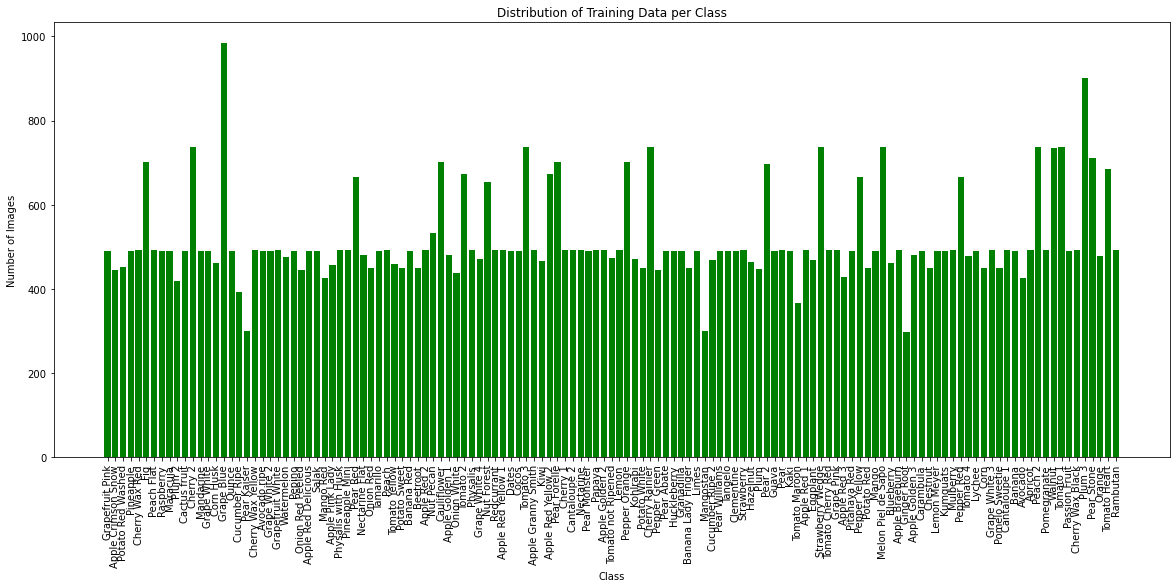

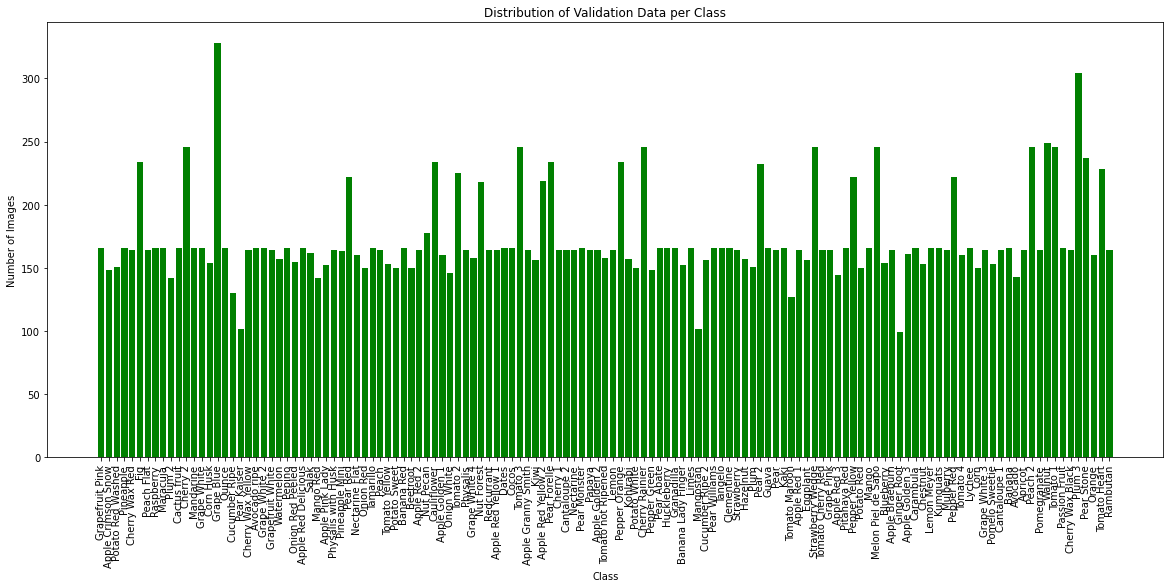

In [ ]:
if presplit:
    plot_images_per_class(images_path, mode='Training', title='Distribution of Training Data per Class')
    plot_images_per_class(images_path, mode='Test', title='Distribution of Validation Data per Class')

In [ ]:
net_model = resnet.resnet18(pretrained=True)
net_name = 'resnet18'

dropout_ratio = 0.25

net_model = load_network(net_model, net_name, dropout_ratio, class_names)

print(f'Images in training set {len(training_set)}, validation set {len(validation_set)}, testing set {len(testing_set)}')

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

11,341,507 total parameters
164,995 training parameters
Images in training set 67692, validation set 22688, testing set 22688


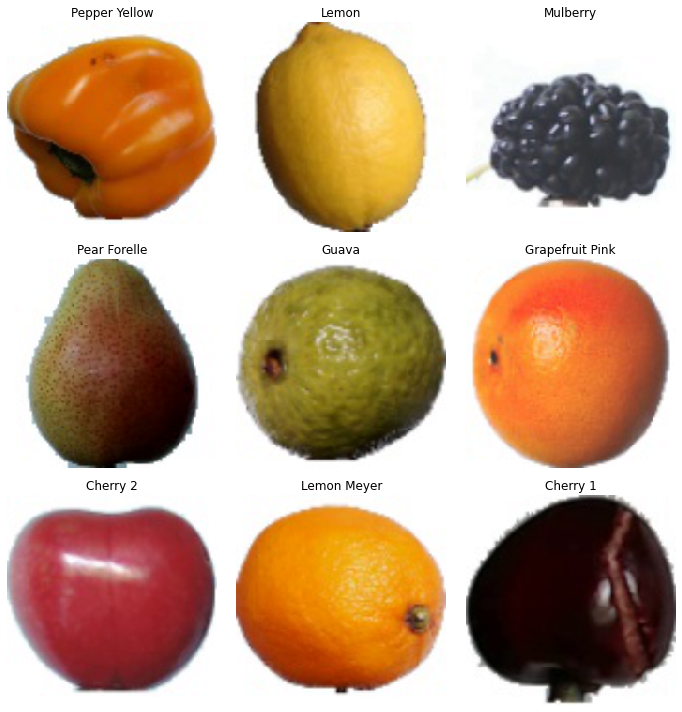

In [ ]:
plot_grid_images(training_set, batch_size, class_names, mean, std, rows=3, columns=3, size=10)

In [ ]:
learning_rate = 0.001
epochs = 100
momentum = 0.9
weight_decay = 0
patience = 3
n_epochs_stop = 5

net_model, loss_acc, y_testing, preds = train_model(results_path, net_name, net_model, training_set_loader, validation_set_loader, 
                                                    learning_rate, epochs, momentum, weight_decay, patience, n_epochs_stop)

Using 1 GPUs
[train] Epoch 1/100 Iteration 1/265 Loss: 4.94 Accuracy: 0.01
[train] Epoch 1/100 Iteration 54/265 Loss: 2.99 Accuracy: 0.45
[train] Epoch 1/100 Iteration 107/265 Loss: 1.86 Accuracy: 0.67
[train] Epoch 1/100 Iteration 160/265 Loss: 1.34 Accuracy: 0.76
[train] Epoch 1/100 Iteration 213/265 Loss: 1.06 Accuracy: 0.81
[train] Epoch 1/100 Iteration 265/265 Loss: 0.88 Accuracy: 0.84
[val] Epoch 1/100 Iteration 1/89 Loss: 0.15 Accuracy: 0.97
[val] Epoch 1/100 Iteration 18/89 Loss: 0.14 Accuracy: 0.96
[val] Epoch 1/100 Iteration 35/89 Loss: 0.15 Accuracy: 0.97
[val] Epoch 1/100 Iteration 52/89 Loss: 0.15 Accuracy: 0.96
[val] Epoch 1/100 Iteration 69/89 Loss: 0.15 Accuracy: 0.96
[val] Epoch 1/100 Iteration 86/89 Loss: 0.16 Accuracy: 0.96
[val] Epoch 1/100 Iteration 89/89 Loss: 0.16 Accuracy: 0.96
[train] Epoch 2/100 Iteration 1/265 Loss: 0.12 Accuracy: 0.98
[train] Epoch 2/100 Iteration 54/265 Loss: 0.10 Accuracy: 0.99
[train] Epoch 2/100 Iteration 107/265 Loss: 0.09 Accuracy: 0.9

[train] Epoch 11/100 Iteration 107/265 Loss: 0.01 Accuracy: 1.00
[train] Epoch 11/100 Iteration 160/265 Loss: 0.01 Accuracy: 1.00
[train] Epoch 11/100 Iteration 213/265 Loss: 0.01 Accuracy: 1.00
[train] Epoch 11/100 Iteration 265/265 Loss: 0.01 Accuracy: 1.00
[val] Epoch 11/100 Iteration 1/89 Loss: 0.03 Accuracy: 0.98
[val] Epoch 11/100 Iteration 18/89 Loss: 0.04 Accuracy: 0.99
[val] Epoch 11/100 Iteration 35/89 Loss: 0.05 Accuracy: 0.99
[val] Epoch 11/100 Iteration 52/89 Loss: 0.04 Accuracy: 0.99
[val] Epoch 11/100 Iteration 69/89 Loss: 0.04 Accuracy: 0.99
[val] Epoch 11/100 Iteration 86/89 Loss: 0.04 Accuracy: 0.99
[val] Epoch 11/100 Iteration 89/89 Loss: 0.04 Accuracy: 0.99
Epochs with no improvement 1
[train] Epoch 12/100 Iteration 1/265 Loss: 0.01 Accuracy: 1.00
[train] Epoch 12/100 Iteration 54/265 Loss: 0.01 Accuracy: 1.00
[train] Epoch 12/100 Iteration 107/265 Loss: 0.00 Accuracy: 1.00
[train] Epoch 12/100 Iteration 160/265 Loss: 0.01 Accuracy: 1.00
[train] Epoch 12/100 Iterati

[val] Epoch 20/100 Iteration 89/89 Loss: 0.03 Accuracy: 0.99
Epoch    20: reducing learning rate of group 0 to 1.0000e-05.
Epochs with no improvement 4
[train] Epoch 21/100 Iteration 1/265 Loss: 0.00 Accuracy: 1.00
[train] Epoch 21/100 Iteration 54/265 Loss: 0.00 Accuracy: 1.00
[train] Epoch 21/100 Iteration 107/265 Loss: 0.00 Accuracy: 1.00
[train] Epoch 21/100 Iteration 160/265 Loss: 0.00 Accuracy: 1.00
[train] Epoch 21/100 Iteration 213/265 Loss: 0.00 Accuracy: 1.00
[train] Epoch 21/100 Iteration 265/265 Loss: 0.00 Accuracy: 1.00
[val] Epoch 21/100 Iteration 1/89 Loss: 0.07 Accuracy: 0.99
[val] Epoch 21/100 Iteration 18/89 Loss: 0.03 Accuracy: 0.99
[val] Epoch 21/100 Iteration 35/89 Loss: 0.03 Accuracy: 0.99
[val] Epoch 21/100 Iteration 52/89 Loss: 0.03 Accuracy: 0.99
[val] Epoch 21/100 Iteration 69/89 Loss: 0.03 Accuracy: 0.99
[val] Epoch 21/100 Iteration 86/89 Loss: 0.03 Accuracy: 0.99
[val] Epoch 21/100 Iteration 89/89 Loss: 0.03 Accuracy: 0.99
Epochs with no improvement 5
Early 

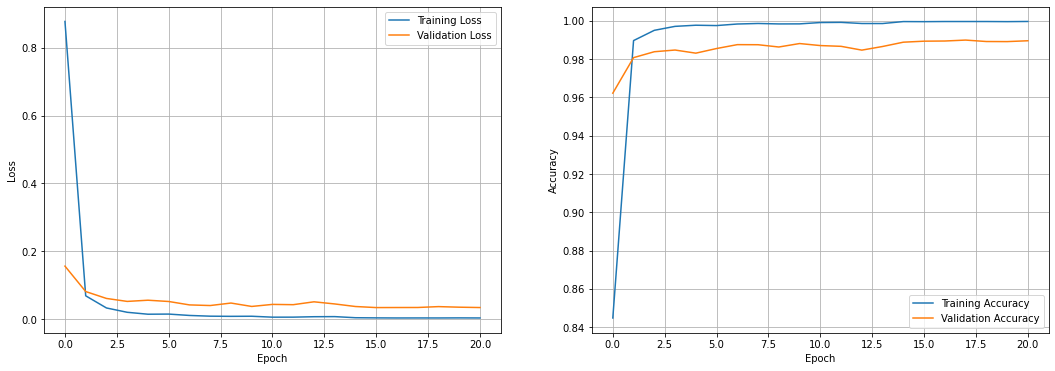

In [ ]:
plot_logs_classification(results_path, net_name, loss_acc)

In [ ]:
preds_test, y_true = test_model(net_name, net_model, testing_set_loader)

Iteration 1/89
Iteration 18/89
Iteration 35/89
Iteration 52/89
Iteration 69/89
Iteration 86/89


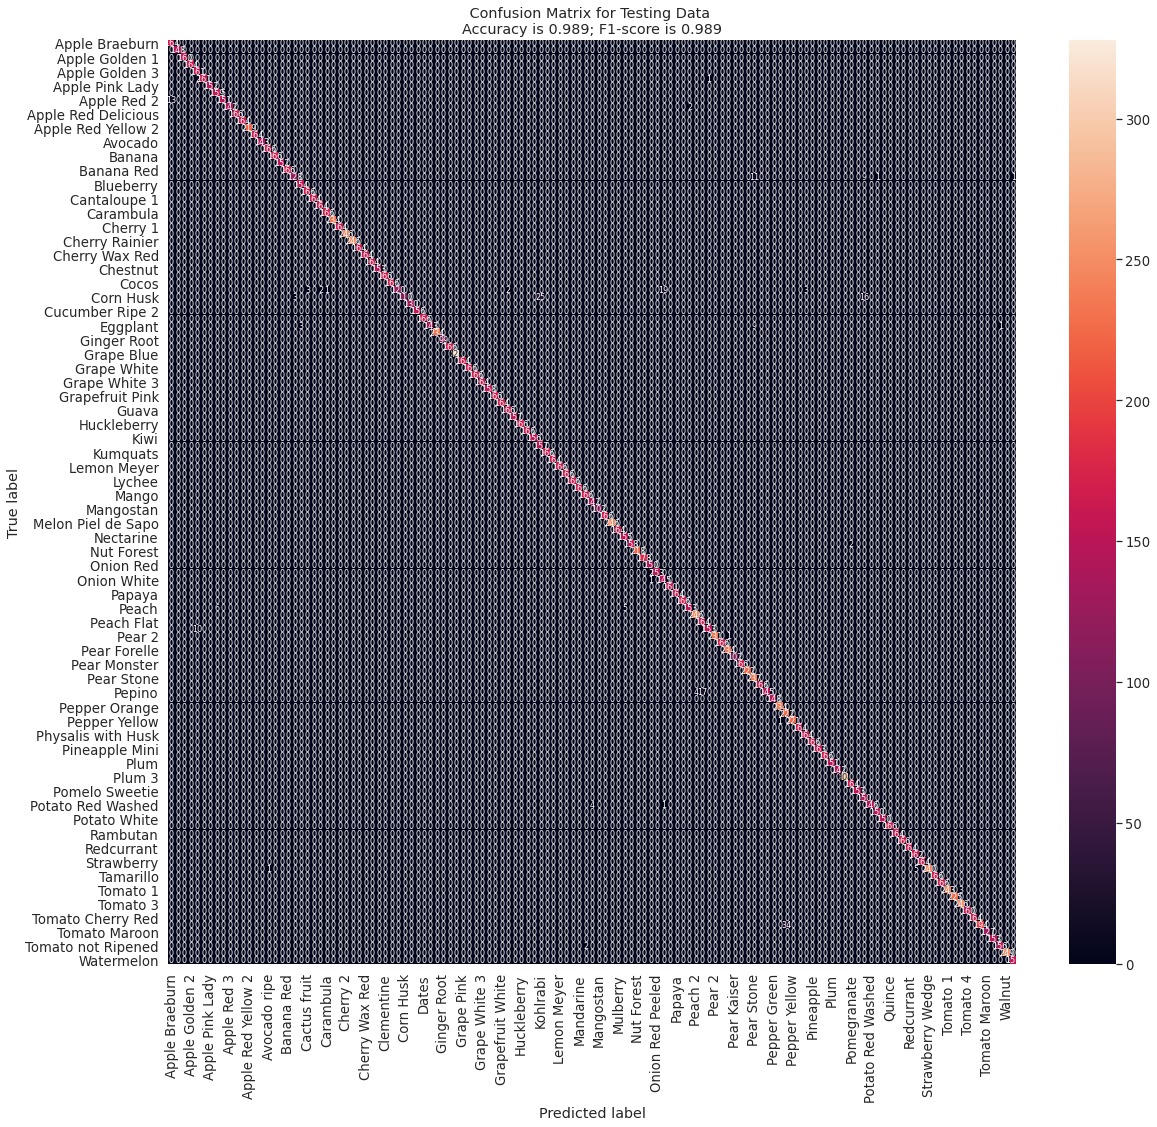

In [ ]:
display_confusion_matrix(results_path, net_name, y_true, preds_test, class_names, annot=True, figsize=(19,17), fontsize=8)

In [ ]:
print(classification_report(y_true, preds_test.argmax(1), target_names=class_names))

                     precision    recall  f1-score   support

     Apple Braeburn       0.93      1.00      0.96       164
 Apple Crimson Snow       1.00      1.00      1.00       148
     Apple Golden 1       1.00      1.00      1.00       160
     Apple Golden 2       1.00      1.00      1.00       164
     Apple Golden 3       0.93      1.00      0.96       161
 Apple Granny Smith       1.00      0.98      0.99       164
    Apple Pink Lady       1.00      1.00      1.00       152
        Apple Red 1       0.96      0.97      0.97       164
        Apple Red 2       0.97      0.92      0.94       164
        Apple Red 3       1.00      0.99      0.99       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       1.00      1.00      1.00       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       1.00      1.00      1.00       164
            Avocado       1.00      1.00      1.00       143
       Avocado ripe    